In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_dataset=pd.read_csv('../input/train.csv', header=0)
test_dataset=pd.read_csv('../input/test.csv', header=0)

#Study features

In [3]:
categorical_features=['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
                      'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                      'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                     'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
                     'MiscFeature','SaleType','SaleCondition']
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
train_dataset.describe()

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,NaN,7553.500000,5.000000,5.000000,1954.000000,1967.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,NaN,9478.500000,6.000000,5.000000,1973.000000,1994.000000,NaN,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,NaN,11601.500000,7.000000,6.000000,2000.000000,2004.000000,NaN,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#Preparing the dataset

## Normalizing

In [4]:
#thanks to https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

every_column_non_categorical= [col for col in train_dataset.columns if col not in categorical_features and col not in ['Id'] ]

#log transform skewed numeric features:
numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index

#skewed_feats = train_dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index

train_dataset[numeric_feats] = np.log1p(train_dataset[numeric_feats])

every_column_non_categorical= [col for col in test_dataset.columns if col not in categorical_features and col not in ['Id'] ]
numeric_feats = test_dataset[every_column_non_categorical].dtypes[test_dataset.dtypes != "object"].index
test_dataset[numeric_feats] = np.log1p(test_dataset[numeric_feats])

## Cleaning

In [5]:
features_with_nan=['Alley','MasVnrType','BsmtQual','BsmtQual','BsmtCond','BsmtCond','BsmtExposure',
                   'BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish']
#function that creates a column for every value it might have
def ConverNaNToNAString(data, columnList):
    for x in columnList:       
        data[x] =str(data[x])              
            

ConverNaNToNAString(train_dataset, features_with_nan)
ConverNaNToNAString(test_dataset, features_with_nan)

## Creating columns from each categorical feature value

In [6]:
#function that creates a column for every value it might have
def CreateColumnPerValue(data, columnList):
    for x in columnList:

        values=pd.unique(data[x])
        
        for v in values:
            column_name=x+"_"+str(v)   
            data[column_name]=(data[x]==v).astype(float)
    
        data.drop(x, axis=1, inplace=True)
        

In [7]:
#CreateColumnPerValue(train_dataset,categorical_features)
#CreateColumnPerValue(test_dataset,categorical_features)

train_dataset = pd.get_dummies(train_dataset,columns =categorical_features)
test_dataset = pd.get_dummies(test_dataset,columns =categorical_features)

#train_dataset = train_dataset.fillna(train_dataset.mean())
#test_dataset = test_dataset.fillna(test_dataset.mean())

## Looking for most relevant features

In [8]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [9]:
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
model.fit(train_dataset[every_column_except_y],train_dataset['SalePrice'])

OrderedDict(sorted(model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 2636),
             ('LotFrontage', 2338),
             ('BsmtUnfSF', 2267),
             ('GrLivArea', 2142),
             ('GarageArea', 1954),
             ('TotalBsmtSF', 1890),
             ('GarageYrBlt', 1885),
             ('1stFlrSF', 1869),
             ('WoodDeckSF', 1445),
             ('OpenPorchSF', 1395),
             ('BsmtFinSF1', 1385),
             ('YearBuilt', 1244),
             ('MoSold', 1225),
             ('MasVnrArea', 1193),
             ('YearRemodAdd', 1133),
             ('2ndFlrSF', 1097),
             ('YrSold', 798),
             ('OverallCond', 654),
             ('EnclosedPorch', 553),
             ('OverallQual', 525),
             ('TotRmsAbvGrd', 515),
             ('BsmtFinSF2', 435),
             ('BedroomAbvGr', 409),
             ('ScreenPorch', 353),
             ('Fireplaces', 311),
             ('Neighborhood_NAmes', 287),
             ('BsmtFullBath', 243),
             ('LotConfig_Inside', 234),
             ('Sal

In [10]:
#Let's remove the less important ones 
most_relevant_features= list( dict((k, v) for k, v in model.booster().get_fscore().items() if v >= 10).keys())
print(most_relevant_features)

['HeatingQC_TA', 'Neighborhood_IDOTRR', 'Neighborhood_StoneBr', 'OpenPorchSF', 'Condition1_RRAn', 'KitchenAbvGr', 'Exterior2nd_AsbShng', 'Neighborhood_NWAmes', 'LandSlope_Mod', 'BldgType_Twnhs', 'YearRemodAdd', 'Electrical_FuseA', 'BldgType_TwnhsE', 'Neighborhood_OldTown', 'ExterQual_Gd', 'Exterior2nd_VinylSd', 'Neighborhood_SawyerW', 'MSSubClass_30', 'HouseStyle_2Story', 'BsmtUnfSF', 'MSSubClass_90', 'LowQualFinSF', 'MSSubClass_50', 'Condition1_RRAe', 'RoofStyle_Hip', 'MSSubClass_80', 'GarageCond_TA', 'MSZoning_RL', 'OverallQual', 'Neighborhood_ClearCr', 'BldgType_Duplex', 'MasVnrArea', 'Exterior1st_MetalSd', 'SaleType_COD', 'RoofStyle_Flat', 'Exterior2nd_Wd Sdng', 'LotShape_IR1', 'SaleCondition_Family', 'Foundation_PConc', 'LotConfig_FR2', 'Functional_Mod', 'CentralAir_N', 'KitchenQual_Gd', 'LandContour_Lvl', 'MSZoning_C (all)', 'Exterior2nd_Plywood', 'Neighborhood_Edwards', 'Neighborhood_Mitchel', 'Exterior1st_CemntBd', 'MSSubClass_20', 'RoofMatl_CompShg', 'Exterior2nd_Wd Shng', 'El

##Analyzing most important features

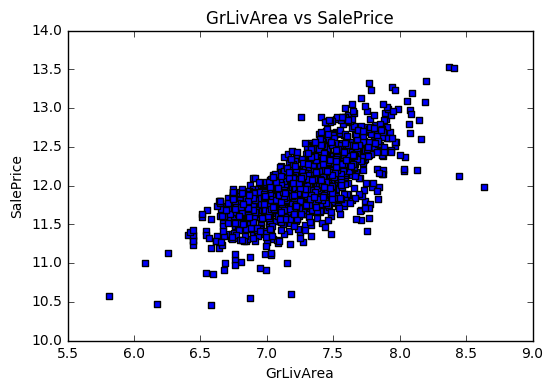

In [11]:
plt.scatter(train_dataset.GrLivArea, train_dataset.SalePrice, c = "blue", marker = "s")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

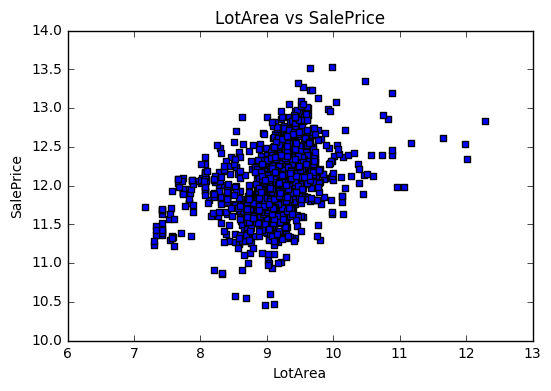

In [12]:
plt.scatter(train_dataset.LotArea, train_dataset.SalePrice, c = "blue", marker = "s")
plt.title("LotArea vs SalePrice")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [13]:
#removing outliers
train_dataset = train_dataset[train_dataset.GrLivArea < 8.25]
train_dataset = train_dataset[train_dataset.LotArea < 11.5]
train_dataset = train_dataset[train_dataset.SalePrice<13]
train_dataset = train_dataset[train_dataset.SalePrice>10.75]
train_dataset.drop("Id", axis=1, inplace=True)

#Calculating best metaparameters

In [14]:
train_x=train_dataset[most_relevant_features]
train_y=train_dataset['SalePrice']

#for tuning parameters
#parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
#}

                    
#xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
#gsearch1.fit(train_x,train_y)
#print (gsearch1.grid_scores_)
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)

best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.07, max_delta_step=0, max_depth=3,
       min_child_weight=1.5, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:linear', reg_alpha=0.75, reg_lambda=0.45,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

#Let's predict for test data and generate submission file

In [15]:
test_dataset['Prediction'] = np.expm1(best_xgb_model.predict(test_dataset[most_relevant_features]))
filename = 'submission.csv'
pd.DataFrame({'Id': test_dataset.Id, 'SalePrice': test_dataset.Prediction}).to_csv(filename, index=False)

In [16]:
print(test_dataset['Prediction'].head())
print(test_dataset['Prediction'].count())

0    126221.796875
1    163231.468750
2    192163.156250
3    195941.109375
4    182045.531250
Name: Prediction, dtype: float32
1459
